# Example of discrete hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

Consider the European call options that at time $T$ pays $X = (S(T) - K)^+$ where $K > 0$ is the strike price.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

In [1]:
import numpy as np

import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.gbm import UnivGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european

In [2]:
seed = 0
np.random.seed(seed)

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.05 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [3]:
s0 = 100
sigma = 0.2
mean = 0.00

params = {
    's0' : s0,
    'dtype' : jnp.float32,
    'mean' : mean,
    'sigma': sigma
}
gmb = UnivGeometricBrownianMotion(**params)

In [4]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1

stock_path = gmb.sample_paths(maturity, N, n_sim)

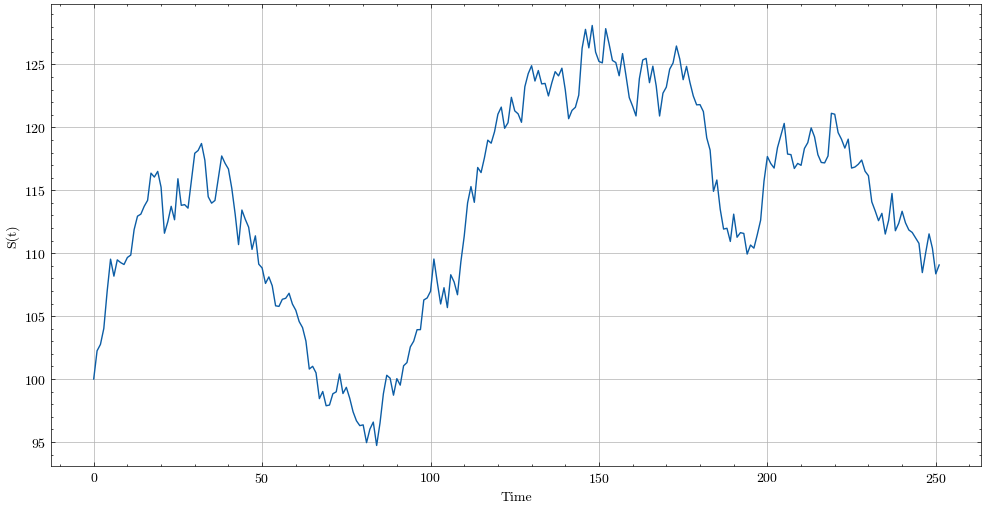

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path)
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [6]:
K = 110
discount_rate = 0.0
dividends = 0.0

In [7]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))

In [8]:
deltas = [v_delta_european(stock_path[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
cs = [european_price(stock_path[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_path[0]]
vs = [cs[0]]

for i in range(1, N):
    vs.append(deltas[i - 1] * stock_path[i] + b[i - 1])
    b.append(vs[i] - deltas[i] * stock_path[i])
    
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path - K, 0)

In [13]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  [0.4003563]


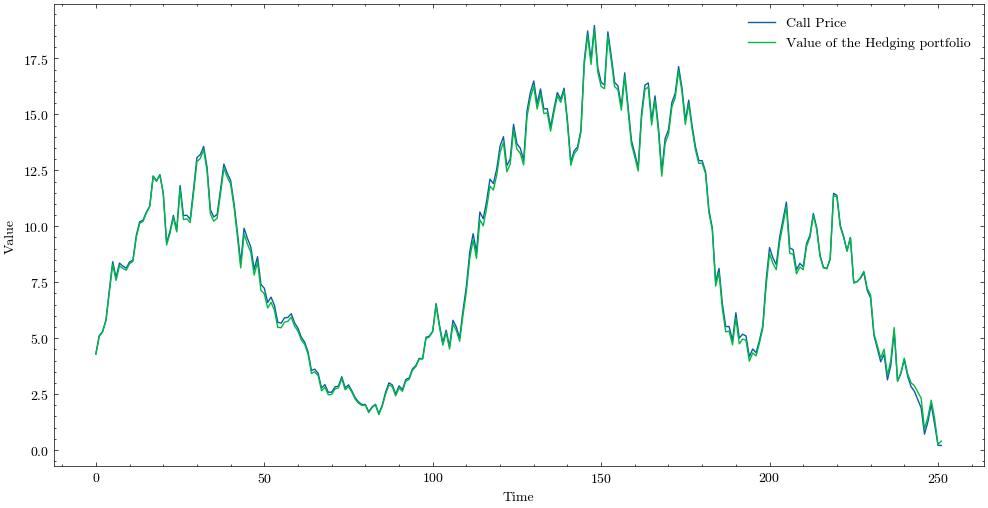

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(cs, label='Call Price')
plt.plot(vs, label='Value of the Hedging portfolio')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()